# Radio Signal Analysis
Σε αυτό το notebook αναλύουμε ραδιοφωνικά σήματα και εφαρμόζουμε τεχνικές επεξεργασίας σήματος. Η διαδικασία περιλαμβάνει την προσομοίωση ενός σήματος, την εξομάλυνσή του, την ανίχνευση της φασματικής γραμμής του υδρογόνου (21 cm) και την προσαρμογή καμπύλης.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy import signal              
from scipy import interpolate         

## 1. Simulating a Radio Signal
Σε αυτό το βήμα δημιουργούμε τα αρχικά μας δεδομένα. Προσομοιώνουμε σήματα που αποτελούνται από υπόβαθρο (background), τυχαίο θόρυβο (noise) και φασματικές γραμμές. 
**Off Signal:** Σήμα αναφοράς χωρίς φασματική γραμμή.
**On Signal:** Σήμα που περιέχει τη φασματική γραμμή στα 1420 MHz.
**Spectral / Spectral2:** Απομονωμένη η φασματική γραμμή για μελλοντική σύγκριση, με κανονική και διπλάσια δειγματοληψία αντίστοιχα.

In [42]:
freqs =  np.linspace(1418, 1422, 1000);


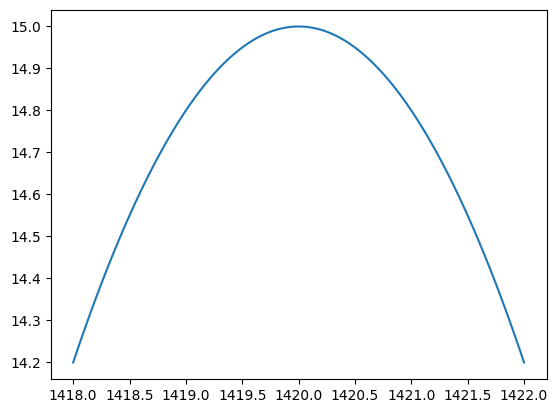

In [43]:
background = -0.2* (freqs- 1420)**2 +15;
plt.plot(freqs, background, label='Background');
plt.show()

In [44]:
steps= 50
noise= np.random.normal(0, 0.5, (steps, len(freqs)));
waterfall_off = background + noise;


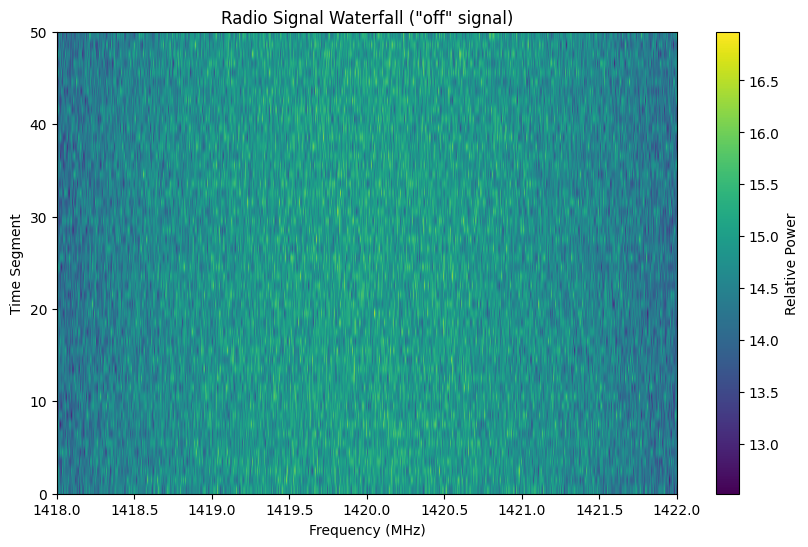

In [45]:
plt.figure(figsize=(10, 6))
plt.imshow(waterfall_off, aspect='auto', extent=[1418, 1422, 0, steps])
plt.colorbar(label='Relative Power')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time Segment')
plt.title('Radio Signal Waterfall ("off" signal)')
plt.show()


In [46]:
A = 2          
f0 = 1420     
sigma = 0.05   


spectral_line = A * np.exp(-((freqs - f0)**2) / (2 * sigma**2))

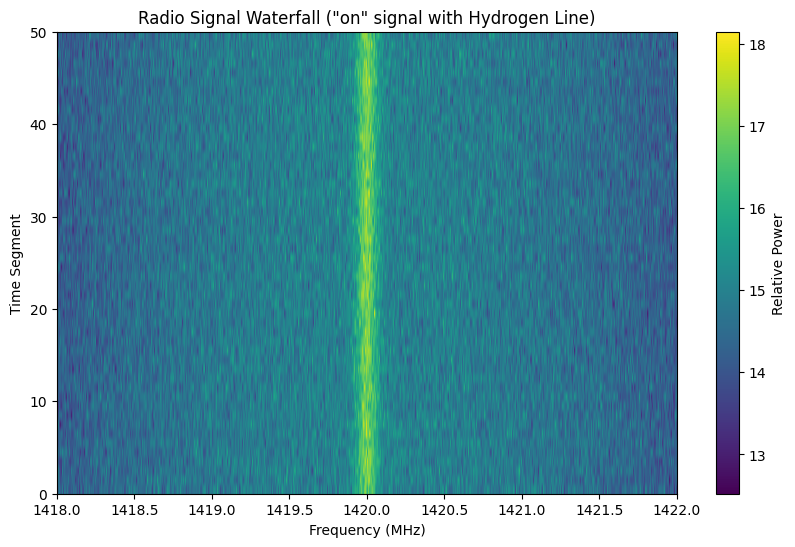

In [47]:
waterfall_on = background + noise + spectral_line
plt.figure(figsize=(10, 6))
plt.imshow(waterfall_on, aspect='auto', extent=[1418, 1422, 0, steps])
plt.colorbar(label='Relative Power')
plt.title('Radio Signal Waterfall ("on" signal with Hydrogen Line)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time Segment')
plt.show()

## 2. Signal Smoothing
Εφαρμόζουμε τεχνικές για να καθαρίσουμε το σήμα μας από τον θόρυβο.
**2.1 Averaging over time:** Υπολογίζουμε τον μέσο όρο των σημάτων (on και off) ως προς τον χρόνο.
**2.2 Removing Background (Calibration):** Αφαιρούμε το υπόβαθρο διαιρώντας το σήμα "on" με το "off" (on/off calibration). Το αποτέλεσμα ονομάζεται "calibrated"[cite: 76].
**2.3 Moving Average:** Εφαρμόζουμε έναν κινητό μέσο όρο με παράθυρο Ν (μονός αριθμός) για περαιτέρω εξομάλυνση. Το τελικό σήμα ονομάζεται "smooth".

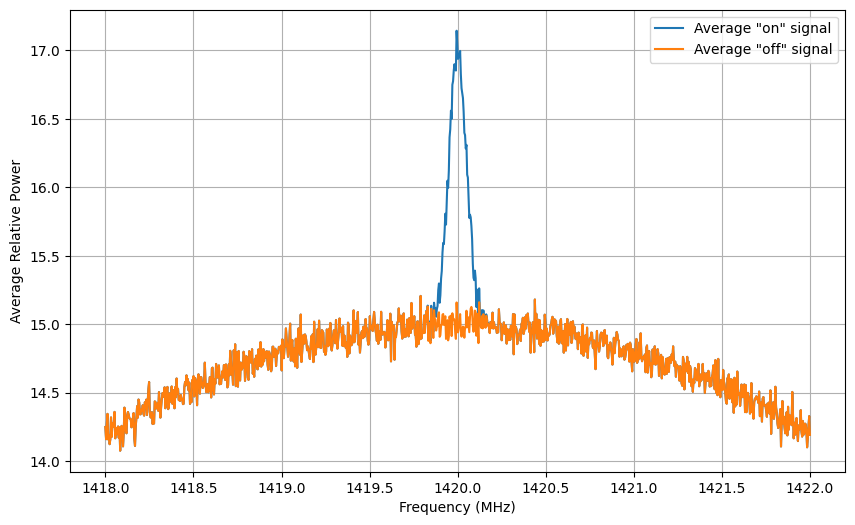

In [48]:

avg_off = np.mean(waterfall_off, axis=0)
avg_on = np.mean(waterfall_on, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(freqs, avg_on, label='Average "on" signal')
plt.plot(freqs, avg_off, label='Average "off" signal')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Average Relative Power')
plt.legend()
plt.grid(True)
plt.show()

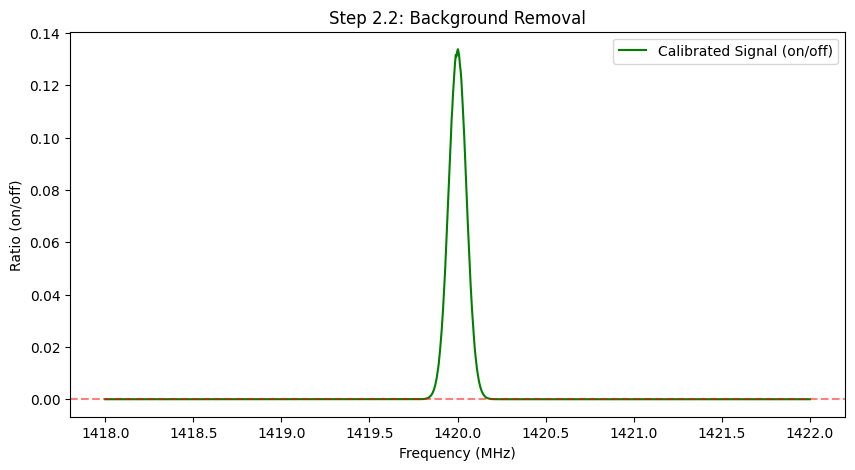

In [49]:
calibrated= (avg_on / avg_off)- 1 

plt.figure(figsize=(10, 5))
plt.plot(freqs, calibrated, color='green', label='Calibrated Signal (on/off)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5) 
plt.xlabel('Frequency (MHz)')
plt.ylabel('Ratio (on/off)')
plt.legend()
plt.title('Step 2.2: Background Removal')
plt.show()

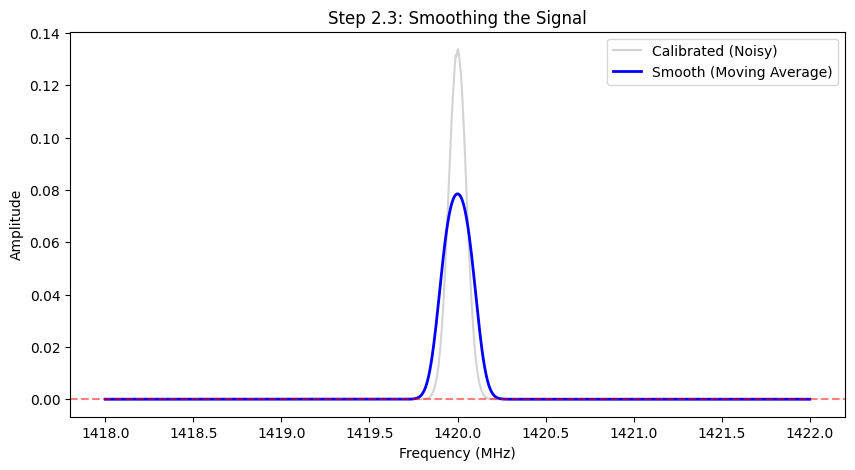

In [50]:
L = len(calibrated)
N = 51  
w = (N - 1) // 2  

smooth = np.zeros(L) 

for i in range(w, L - w):
    smooth[i] = np.mean(calibrated[i - w:i + w + 1])  

plt.figure(figsize=(10, 5))
plt.plot(freqs, calibrated, color='lightgray', label='Calibrated (Noisy)')
plt.plot(freqs, smooth, color='blue', linewidth=2, label='Smooth (Moving Average)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5) 
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Step 2.3: Smoothing the Signal')
plt.show()

In [51]:
mask = (freqs > 1419.5) & (freqs < 1420.5)

freqs_region = freqs[mask]
smooth_region = smooth[mask]

In [52]:
peak_index = np.argmax(smooth_region)

peak_freq = freqs_region[peak_index] 

print(f"Η κορυφή της φασματικής γραμμής βρίσκεται στα: {peak_freq:.2f} MHz")

Η κορυφή της φασματικής γραμμής βρίσκεται στα: 1420.00 MHz


In [53]:
freqs2 = np.linspace(1418, 1422, 2000)

smooth2 = np.interp(freqs2, freqs, smooth)

## 5. Spectral Line Fitting & 6. Error Estimation
Σε αυτό το κρίσιμο βήμα, προσαρμόζουμε μια κανονική κατανομή (Gaussian fit) στα δεδομένα μας. 

**Παρατήρηση:** Όπως φαίνεται στα γραφήματα, το ύψος της προσαρμοσμένης καμπύλης (fit) είναι αισθητά μικρότερο από το αρχικό ιδανικό σήμα (spectral). Αυτό είναι ένα αναμενόμενο αποτέλεσμα της ανάλυσής μας. Η διαδικασία του Calibration (διαίρεση on/off) και το Smoothing (κινητός μέσος όρος) μείωσαν το σχετικό πλάτος και "πλάτυναν" την κορυφή του αρχικού σήματος. Υπολογίζουμε το Μέσο Τετραγωνικό Σφάλμα (MSE) για να αξιολογήσουμε ποσοτικά αυτή τη διαφορά.

In [54]:
from scipy.optimize import curve_fit

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt, pcov = curve_fit(gaussian, freqs, smooth, p0=[1.0, 1420.0, 0.05])

print(f"Βρέθηκαν οι παράμετροι: Ύψος={popt[0]:.2f}, Κέντρο={popt[1]:.2f}, Πλάτος={popt[2]:.4f}")


fit = gaussian(freqs, *popt)
fit2 = gaussian(freqs2, *popt)

Βρέθηκαν οι παράμετροι: Ύψος=0.08, Κέντρο=1420.00, Πλάτος=0.0830


In [55]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: C:\Users\lazar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [56]:
from scipy.optimize import curve_fit

initial_guess = [1.0, 1420.0, 0.05]


def gaussian_with_offset(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))


popt, pcov = curve_fit(
    gaussian_with_offset, 
    freqs2, 
    smooth2, 
    p0=[1.0, 1420.0, 0.05],
)

spectral2 = A * np.exp(-((freqs2 - f0)**2) / (2 * sigma**2))

fit = gaussian_with_offset(freqs, *popt)
fit2 = gaussian_with_offset(freqs2, *popt)

mse1 = np.mean((spectral_line - fit)**2)
mse2 = np.mean((spectral2 - fit2)**2)

print(f"Βέλτιστο ύψος (a): {popt[0]:.4f}")
print(f"MSE (1000 δείγματα): {mse1:.10f}")
print(f"MSE (2000 δείγματα): {mse2:.10f}")

Βέλτιστο ύψος (a): 0.0820
MSE (1000 δείγματα): 0.0799914041
MSE (2000 δείγματα): 0.0800314399


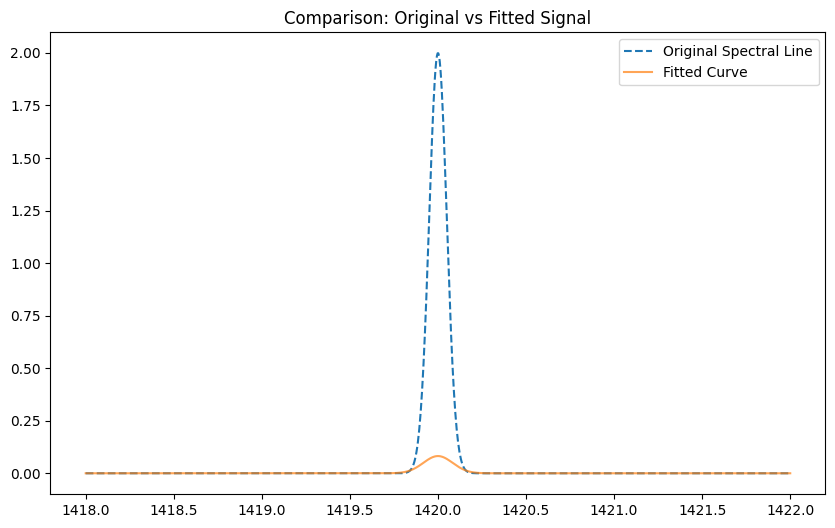

In [57]:
fit_signal = gaussian(freqs, *popt)

plt.figure(figsize=(10, 6))
plt.plot(freqs, spectral_line, label='Original Spectral Line', linestyle='--')
plt.plot(freqs, fit_signal, label='Fitted Curve', alpha=0.7)
plt.title('Comparison: Original vs Fitted Signal')
plt.legend()
plt.show()

In [58]:
spectral2 = A * np.exp(-((freqs2 - f0)**2) / (2 * sigma**2))

fit2 = gaussian(freqs2, *popt)

In [59]:
mse1 = np.mean((spectral_line - fit_signal)**2)

mse2 = np.mean((spectral2 - fit2)**2)

print(f"MSE (1000 δείγματα): {mse1:.6f}")
print(f"MSE (2000 δείγματα): {mse2:.6f}")

MSE (1000 δείγματα): 0.079991
MSE (2000 δείγματα): 0.080031
